# Import 

In [3]:
%matplotlib notebook

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.ticker as plticker
import matplotlib.cm as cm
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.ticker import MaxNLocator, NullLocator, ScalarFormatter
from mpl_toolkits.axes_grid1 import make_axes_locatable

from scipy.stats import gaussian_kde

from astropy.modeling import models, fitting

import numpy as np
import h5py

from time import time

import sys
sys.path.insert( 1, "/home/ngillet/myPythonLibrary" )

import pyemma.utils_functions as utils

from machine_learnig_utils import *

### LC color from Brad and Andrei
EoR_colour = matplotlib.colors.LinearSegmentedColormap.from_list('EoR_colour', 
                                                                 [(0, 'white'),
                                                                  (0.21, 'yellow'),
                                                                  (0.42, 'orange'),
                                                                  (0.63, 'red'),
                                                                  (0.86, 'black'),
                                                                  (0.9, 'blue'),
                                                                  (1, 'cyan')])

%load_ext autoreload
%autoreload 2

In [2]:
#%load_ext watermark
#%watermark -v -m -p  numpy,scipy,matplotlib,keras,theano,tensorflow,sklearn

# DATA load

## The parameter file

In [6]:
### param_all4_1Davg
 
### param_all4_2D            ### no drop out    : good, but less than param_all4_2D_drop
### param_all4_2D_drop = REF ### drop out = 20% : good result, validation NOT CHECK

### param_all4_2D_smallFilter == param_all4_2D_drop + lower number of filters
### param_all4_2D_1batchNorm  == param_all4_2D_drop + 1 batchNorm at beggening
### param_all4_2D_smallFilter_1batchNorm

from param_all4_2D_smallFilter_1batchNorm_multiSlice_dataGenerator import * ###

In [7]:
### INITIATE RANDOM STATE
#RandomSeed = 2235
np.random.RandomState( np.random.seed(RandomSeed) )

from lightcone_functions import LOAD_DATA

print( 'Param          :', paramName[paramNum] )
print( 'file           :', model_file )
print( 'RandomSeed     :', RandomSeed )
print( 'trainSize      :', trainSize )
print( 'LHS            :', LHS )
if( LHS ):
    print( 'Nbins_LHS      :', Nbins_LHS )
print( 'epochs         :', epochs )
print( 'batch_size     :', batch_size )
print( 'DATABASE       :', DATABASE )
print( 'validation     :', validation )
print( 'all4           :', all4           )
print( 'reduce_LC      :', reduce_LC      )
print( 'use_dropout    :', use_dropout    )
print( 'substract_mean :', substract_mean )
print( 'apply_gauss    :', apply_gauss    )
print( 'CNN loss       :', loss )
print( 'CNN optimizer  :', optimizer )
print( 'LR factor      :', factor)
print( 'LR patience    :', patience)

### Variables not define in all parameter file!!
try:
    print( 'LeackyRelu     :',LeackyRelu_alpha )
except:
    LeackyRelu_alpha = 0
    print( 'LeackyRelu     :',LeackyRelu_alpha )
    
try:
    print( 'batchNorm      :',batchNorm )
except:
    batchNorm = False
    print( 'batchNorm      :',batchNorm )
      
try:
    print( 'FirstbatchNorm :',FirstbatchNorm )
except:
    FirstbatchNorm = False
    print( 'FirstbatchNorm :',FirstbatchNorm )
     
try:
    print( 'Nfilter1       :',Nfilter1 )
    print( 'Nfilter2       :',Nfilter2 )
    print( 'Nfilter3       :',Nfilter3 )
except:
    Nfilter1 = 16 
    Nfilter2 = 32 
    Nfilter3 = 64 
    print( 'Nfilter1       :',Nfilter1 )
    print( 'Nfilter2       :',Nfilter2 )
    print( 'Nfilter3       :',Nfilter3 )

Param          : all4
file           : all4_2D_smallFilter_1batchNorm_multiSlice_dataGenerator
RandomSeed     : 4321
trainSize      : 0.8
LHS            : False
epochs         : 200
batch_size     : 20
DATABASE       : 100_2200_slice_10
validation     : True
all4           : True
reduce_LC      : False
use_dropout    : 0.2
substract_mean : False
apply_gauss    : False
CNN loss       : mean_squared_error
CNN optimizer  : RMSprop
LR factor      : 0.5
LR patience    : 5
LeackyRelu     : 0
batchNorm      : False
FirstbatchNorm : True
Nfilter1       : 8
Nfilter2       : 16
Nfilter3       : 64


## Associated data

In [8]:
HDF5 = True
DATA_DIR = '/media/yqin/81614149-2ed8-4c76-82e1-c46763d086fa/ngillet/LC_SLICE10_px100_2200_N10000_randICs_train.hdf5'
    
from lightcone_functions import DataGenerator 
# Data Generator Parameters
if not(HDF5):
    DATA_DIR='/media/yqin/81614149-2ed8-4c76-82e1-c46763d086fa/ngillet/LC_SLICE10_px100_2200_N10000_randICs/train/'
params_train = {'Ndata'      : 80000,
                'batch_size' : 20, 
                'dim'        : (100,2200), 
                'n_channels' : 1,
                'n_params'   : 4, 
                'shuffle'    : True, 
                'DATA_DIR'   : DATA_DIR, 
                'HDF5'       : HDF5, 
                'which_set'  : 'train',
                'pre_loaded_data' : True, 
               }
if not(HDF5):
    DATA_DIR='/media/yqin/81614149-2ed8-4c76-82e1-c46763d086fa/ngillet/LC_SLICE10_px100_2200_N10000_randICs/validation/'
params_valid = {'Ndata'      : 1000,
                'batch_size' : 20, 
                'dim'        : (100,2200), 
                'n_channels' : 1,
                'n_params'   : 4, 
                'shuffle'    : True, 
                'DATA_DIR'   : DATA_DIR_val, 
                #'pre_loaded_data' : True, 
                'HDF5'       : HDF5, 
                'which_set'  : 'validation',
               }
if not(HDF5):
    DATA_DIR='/media/yqin/81614149-2ed8-4c76-82e1-c46763d086fa/ngillet/LC_SLICE10_px100_2200_N10000_randICs/test/'
params_test  = {'Ndata'      : 1000,
                'batch_size' : 20, 
                'dim'        : (100,2200), 
                'n_channels' : 1,
                'n_params'   : 4, 
                'shuffle'    : False, 
                'DATA_DIR'   : DATA_DIR, 
                #'pre_loaded_data' : True, 
                'HDF5'       : HDF5, 
                'which_set'  : 'test',
               }

# Generators
training_generator   = DataGenerator( **params_train)
validation_generator = DataGenerator( **params_valid)
test_generator       = DataGenerator( **params_test)

# Files

In [10]:
print( name )
print( model_file )
print( prediction_file )
print( prediction_file_val )
print( history_file )

model_file_ = CNN_folder+model_file
history_file_ = CNN_folder+history_file +'.npy'
prediction_file_ = CNN_folder+prediction_file +'.npy'
prediction_validation_file_ = CNN_folder+prediction_file_val+'.npy'

_smallFilter_1batchNorm_multiSlice_dataGenerator
all4_2D_smallFilter_1batchNorm_multiSlice_dataGenerator
all4_2D_smallFilter_1batchNorm_multiSlice_dataGenerator_pred
all4_2D_smallFilter_1batchNorm_multiSlice_dataGenerator_pred_val
all4_2D_smallFilter_1batchNorm_multiSlice_dataGenerator_history


# $\rm{R^2}$ SCORE

In [11]:
model_loaded = load_model( model_file_ )

In [61]:
### LOAD THE PARAM TO COMPUTE THE R2

pred_testing = np.load( prediction_file_ )
#pred_validation = np.load( prediction_validation_file_ )

with h5py.File(DATA_DIR, 'r') as f:
    for key in f.keys():
        print(key)
        
    Param_test = f["Param_test"][:]
    Param_raw_test = f["Param_raw_test"][:]
    #Param_val = f["Param_val"][:]
    #Param_raw_val = f["Param_raw_val"][:]
    
Param_raw_test[:,-1] /= 1000.
################################
################################

#pred_testing    = model_loaded.predict_generator( test_generator, verbose=True )
#np.save( prediction_file_, pred_testing )

################################
################################

#pred_validation = model_loaded.predict_generator( validation_generator, verbose=True )
#np.save( prediction_validation_file_, pred_validation )

LC_test
LC_train
LC_val
Param_raw_test
Param_raw_train
Param_raw_val
Param_test
Param_train
Param_val


In [62]:
1 - ((pred_testing - Param_test)**2).sum(axis=0) / ((pred_testing - pred_testing.mean(axis=0))**2).sum(axis=0)

array([0.96144754, 0.9945764 , 0.98323035, 0.716002  ], dtype=float32)

In [30]:
#1 - ((pred_validation - Param_val)**2).sum(axis=0) / ((pred_validation - pred_validation.mean(axis=0))**2).sum(axis=0)

In [63]:
print('Test')
print_R2( prediction_file_           , [0,1,2,3], Param_test )
#print('Validation')
#print_R2( prediction_validation_file_, [0,1,2,3], Param_val )

Test
R2 ZETA:  0.9614475779235363
R2 Tvir:  0.9945763661526144
R2 LX:  0.9832303524017334
R2 E0:  0.7160016000270844


# PLOTS

### Loss

<IPython.core.display.Javascript object>


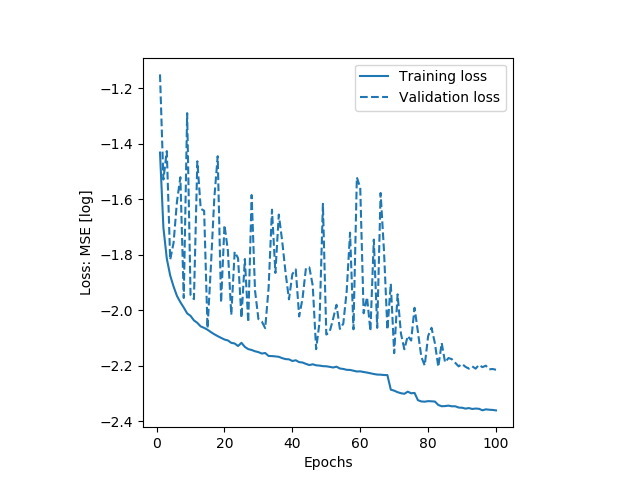

plots/all4_2D_smallFilter_1batchNorm_multiSlice_dataGenerator_loss.pdf
plots/all4_2D_smallFilter_1batchNorm_multiSlice_dataGenerator_loss


In [64]:
fig_history = plot_history( history_file_, model_file, fig=None, save=True )

if 1: 
    plot_file = 'plots/%s'%model_file+'_loss'
    print( plot_file )
    fig_history.savefig( plot_file, bbox_inches='tight', format='pdf')


### Pred vs True

In [65]:
Brad_faint = np.array( [ [ [ 30  , 33.99, 7.18, 5.13 ], 
                           [ 4.70, 4.76 , 0.07, 0.07 ],
                           [ 40  , 40.08, 0.1 , 0.1  ],
                           [ 0.5 , 0.52 , 0.07, 0.08 ] ], 
                        
                         [ [ 200 , 177.42, 33.62, 30.85 ], 
                           [ 5.48, 5.47  , 0.02 , 0.02  ],
                           [ 40  , 40    , 0.07 , 0.07  ],
                           [ 0.5 , 0.5   , 0.07 , 0.08  ] ]
                       ] )

[249.82518     5.998934   41.99556     1.4992862]
R2 ZETA:  0.9614475779235363
plots/ZETA_smallFilter_1batchNorm_multiSlice_dataGenerator.pdf
249.82518
number of points:  1000


<IPython.core.display.Javascript object>


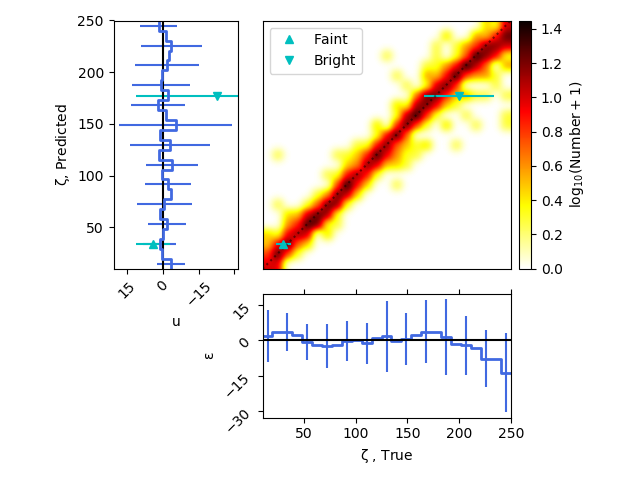

plots/ZETA_smallFilter_1batchNorm_multiSlice_dataGenerator
R2 Tvir:  0.9945763661526144
plots/Tvir_smallFilter_1batchNorm_multiSlice_dataGenerator.pdf
5.998934
number of points:  1000


<IPython.core.display.Javascript object>


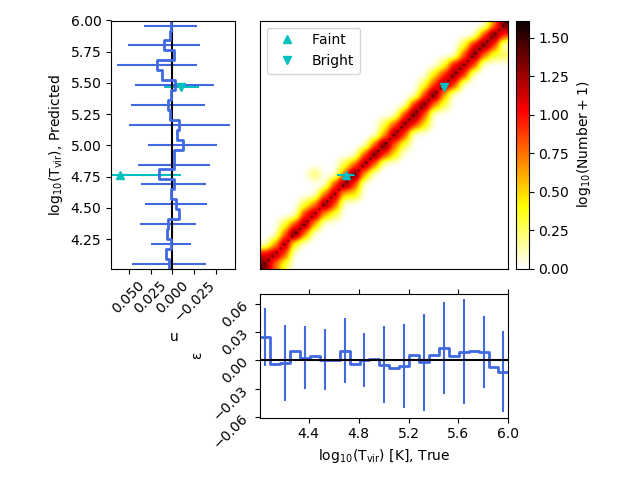

plots/Tvir_smallFilter_1batchNorm_multiSlice_dataGenerator
R2 LX:  0.9832303524017334
plots/LX_smallFilter_1batchNorm_multiSlice_dataGenerator.pdf
41.99556
number of points:  1000


<IPython.core.display.Javascript object>


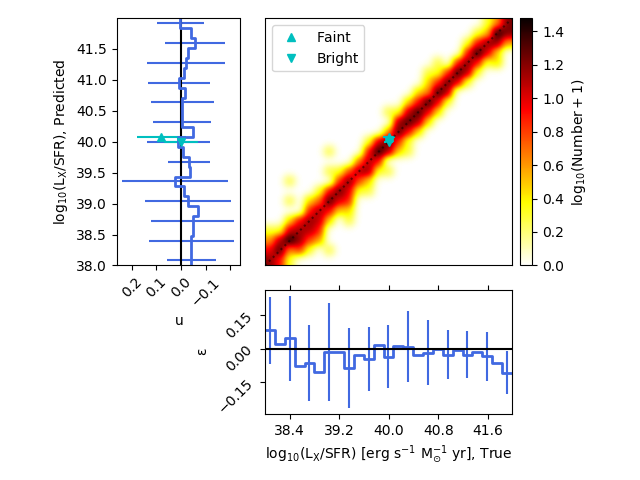

plots/LX_smallFilter_1batchNorm_multiSlice_dataGenerator
R2 E0:  0.7160016000270844
plots/E0_smallFilter_1batchNorm_multiSlice_dataGenerator.pdf
1.4992862
number of points:  1000


<IPython.core.display.Javascript object>


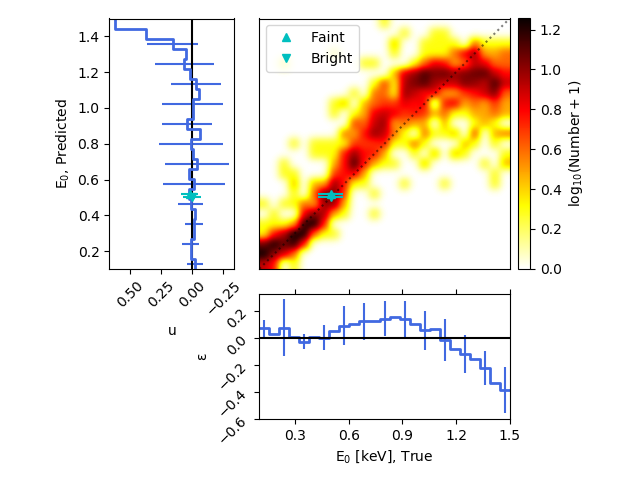

plots/E0_smallFilter_1batchNorm_multiSlice_dataGenerator


In [66]:
bin_true, eps_mean, eps_std, u_mean, u_std = plot_result( prediction_file_, [0,1,2,3], 
                                                          Param_test, Param_raw_test, 
                                                          name,
                                                          Nbin=25+1, 
                                                          save=True, 
                                                          Brad_pt=Brad_faint  
                                                        ) # [0,1,2,3]

### Test Marginalize proba

In [83]:
paramNum = 3
Nbin = 25+1

out_model = load_pred( prediction_validation_file_ )

pmin = Param_raw_val[:,paramNum].min() ### minimum of the selected parameter
d    = Param_raw_val[:,paramNum].max() - pmin ### range of the selected parameter
VALUE_TRUE = Param_val[:,paramNum]*d+pmin ### recovert 'physical value' of input
VALUE_PRED = out_model[:,paramNum]*d+pmin ### recovert 'physical value' of output
RESIDUAL = (VALUE_PRED - VALUE_TRUE)

bin_VALUE_TRUE = np.linspace( VALUE_TRUE.min(), VALUE_TRUE.max(), Nbin )


In [84]:
### U 

### distribution of predictions
h, xh = np.histogram( VALUE_PRED, bins=bin_VALUE_TRUE )

### distribution of predictions weight per residual
h_weight, xh_weight = np.histogram( VALUE_PRED, bins=bin_VALUE_TRUE, weights=RESIDUAL )

bin_RESIDUAL = np.linspace( RESIDUAL.min(), RESIDUAL.max(), Nbin )
h_2D, y2D, x2D = np.histogram2d( VALUE_PRED, RESIDUAL, bins=[bin_VALUE_TRUE, bin_RESIDUAL] )

### get stat
h_id = np.digitize( VALUE_PRED, bin_VALUE_TRUE ) ### return bin ID of the pred
std = np.zeros(Nbin-1)
mean = np.zeros(Nbin-1)
median = np.zeros(Nbin-1)

### for each bin compute the stat
for i in range(Nbin-1):
    id_ = np.where( h_id==(i+1) )[0]
    mean[i] = RESIDUAL[id_].sum() / id_.size
    median[i] = np.median( RESIDUAL[id_] )
    std[i] =  np.sqrt( (( RESIDUAL[id_] - mean[i] )**2).sum() / (id_.size-1) )

/home/ngillet/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars


<IPython.core.display.Javascript object>


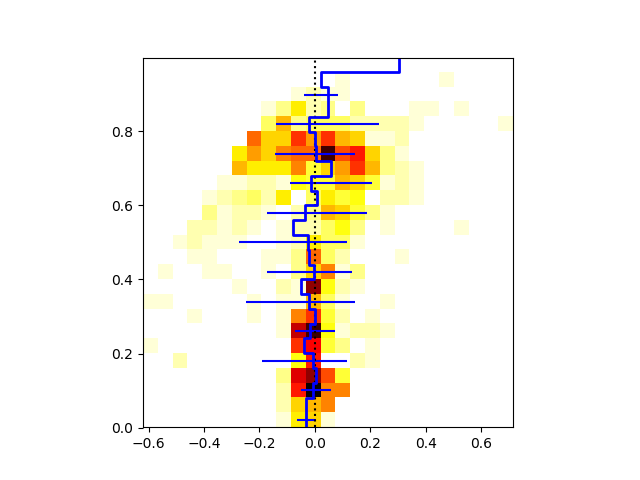

In [85]:
fig, ax = plt.subplots()

plt.imshow( h_2D, cmap='hot_r', origin='lower',
           extent=[x2D[0],x2D[-1],y2D[0],y2D[-1]] )

x0,x1 = plt.xlim()
y0,y1 = plt.ylim()
ax.set_aspect( (x1-x0)/(y1-y0) )

plt.errorbar( mean, utils.zcen(bin_VALUE_TRUE), xerr=std, ecolor='b', fmt='.', color='b', ms=0, errorevery=2 )
plt.step( np.append( mean[0], mean ), bin_VALUE_TRUE, where='pre', lw=2, color='b' )#, label='mean' )

plt.vlines( 0, y0, y1, linestyle=':' )

In [ ]:
#fig, ax = plt.subplots()

for line in h_2D

In [ ]:
h_2D.shape

In [ ]:
plt.figure()

plt.errorbar( utils.zcen(bin_VALUE_TRUE), mean, yerr=std, ecolor='b', fmt='.', color='b', ms=0, errorevery=2 )
plt.step( bin_VALUE_TRUE, np.append( mean[0], mean ), where='pre', lw=2, color='b' )#, label='mean' )
    
plt.plot( [bin_VALUE_TRUE[0],bin_VALUE_TRUE[-1]], [0,0], 'k-' )
plt.xlim( bin_VALUE_TRUE[0], bin_VALUE_TRUE[-1] )


### For a random distribution

In [ ]:
range_physical_value = [ 1, 100 ]
physical_value       = np.random.rand( 4000 ) * ( range_physical_value[1] - range_physical_value[0] ) + range_physical_value[0]
infer_physical_value = np.random.rand( 4000 ) * ( range_physical_value[1] - range_physical_value[0] ) + range_physical_value[0]

num_rand = 0
Nbin_rand=20+1
rand_range = [[1], [100]]
out_rand   = np.random.rand( 4000 )
inp_rand   = np.random.rand( 4000 )

f_rand = plot_CNN_out( out_rand, inp_rand[:,np.newaxis], num_rand, rand_range[0], rand_range[1], color='b', Nbin=Nbin_rand )

### individual error

<IPython.core.display.Javascript object>


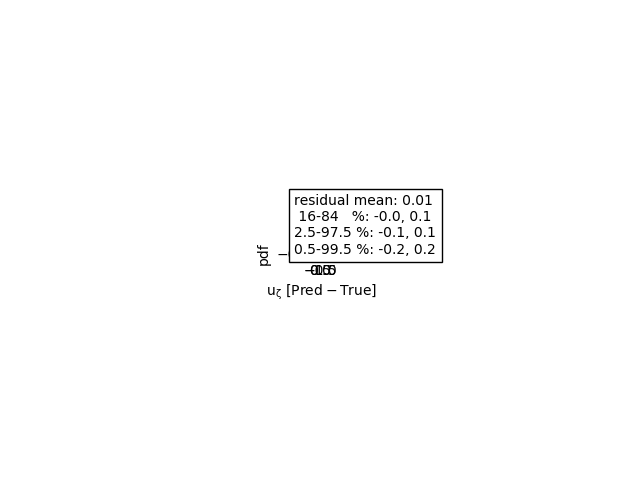

residual mean: 0.007170858929536352
residual std : 0.05606522557420729
16-84 percentil : -0.02270098763628373 0.05163726941523941
2.5-97.5 percentil : -0.09556471422764806 0.1257663612696945
0.5-99.5 percentil : -0.20751270160257423 0.20461531029069466
R2 ZETA:  0.9602750938532639
plots/ZETA_smallFilter_1batchNorm_multiSlice_dataGenerator_error.pdf
plots/ZETA_smallFilter_1batchNorm_multiSlice_dataGenerator_error


/home/ngillet/anaconda3/lib/python3.6/site-packages/matplotlib/tight_layout.py:177: UserWarning: The left and right margins cannot be made large enough to accommodate all axes decorations. 
  warnings.warn('The left and right margins cannot be made large '


<IPython.core.display.Javascript object>


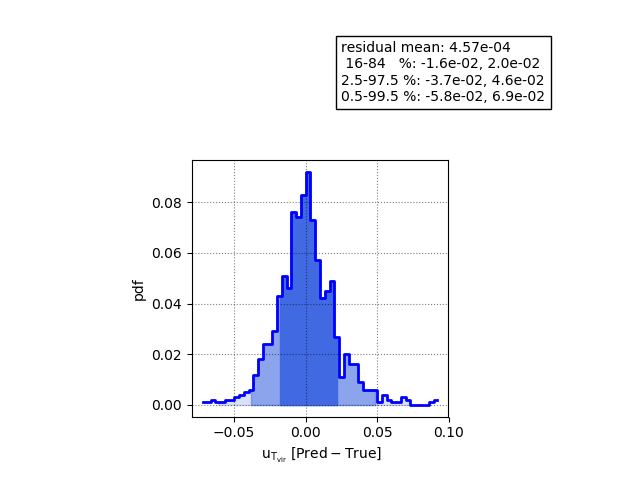

residual mean: 0.0004565065669524967
residual std : 0.020612314051648102
16-84 percentil : -0.01628942716652059 0.01987303066728811
2.5-97.5 percentil : -0.036540548828377824 0.04619812957482964
0.5-99.5 percentil : -0.058188005867339083 0.06948815192615505
R2 Tvir:  0.9947463468324743
plots/Tvir_smallFilter_1batchNorm_multiSlice_dataGenerator_error.pdf
plots/Tvir_smallFilter_1batchNorm_multiSlice_dataGenerator_error


<IPython.core.display.Javascript object>


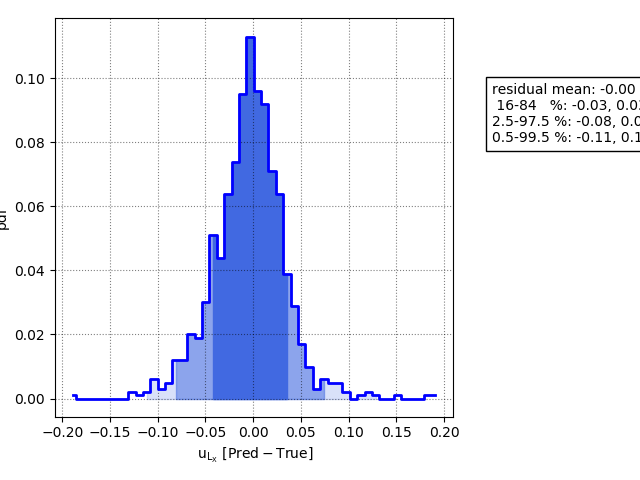

residual mean: -0.004392537560552113
residual std : 0.037020611929910976
16-84 percentil : -0.03476515610588704 0.03093213750256589
2.5-97.5 percentil : -0.07735341886431538 0.07168188879539661
0.5-99.5 percentil : -0.10766344433341114 0.12064349360059692
R2 LX:  0.9831631619629343
plots/LX_smallFilter_1batchNorm_multiSlice_dataGenerator_error.pdf
plots/LX_smallFilter_1batchNorm_multiSlice_dataGenerator_error


<IPython.core.display.Javascript object>


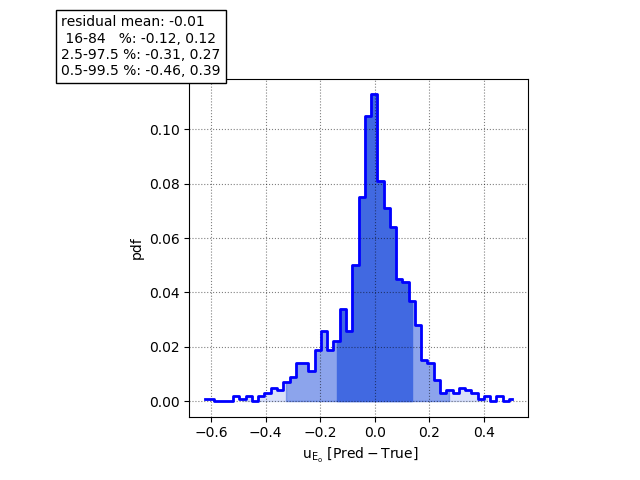

residual mean: -0.010355444338138259
residual std : 0.13921660293214727
16-84 percentil : -0.11887424392371929 0.12043787970493448
2.5-97.5 percentil : -0.31069550001530366 0.2671910124381305
0.5-99.5 percentil : -0.4619817500180491 0.38987064703066293
R2 E0:  0.7084577976071926
plots/E0_smallFilter_1batchNorm_multiSlice_dataGenerator_error.pdf
plots/E0_smallFilter_1batchNorm_multiSlice_dataGenerator_error


In [79]:
plot_result_2( prediction_file_, [0,1,2,3], Param_test , Param_raw_test, name, Nbin=50+1, save=True ) # [0,1,2,3]

## Plot TRUE-PREDICTED with selection

### select by $x_{z=6}$ and\or $\tau$

In [16]:
tau_dir = '/amphora/bradley.greig/21CMMC_wTs_LC_RSDs_Nicolas/Programs/TauData/'
tau_file_format = 'Tau_e_0.000000_{}.000000.txt'

tau = np.array( [ np.loadtxt( tau_dir+tau_file_format.format(i) ) for i in range(10000) ] )

In [17]:
xion_dir = '/amphora/bradley.greig/21CMMC_wTs_LC_RSDs_Nicolas/Programs/AveData/'
xion_file_format = 'AveData_0.000000_{}.000000.txt'

xionz6 = np.array( [ np.loadtxt( xion_dir+xion_file_format.format(i), usecols=1 )[-1] for i in range(10000) ] )

In [ ]:
### Load the data ID
DATA_ID = LOAD_DATA( RandomSeed=RandomSeed,
                     trainSize=trainSize,
                     LHS=LHS,
                     verbose=True,
                     Nbins_LHS=Nbins_LHS,
                     DATABASE=DATABASE,
                     justParam=False,
                     reduce_LC=reduce_LC, 
                     substract_mean=substract_mean,
                     apply_gauss=apply_gauss,
                     validation=validation,
                     justDataID=True )

train_select, test_select, validation_select = DATA_ID

In [ ]:
### CHECK IF THE ID ARE THE GOOD ONES
#from lightcone_functions import read_1_param
#param_raw_test = np.array( [ read_1_param( param=None, ICs=3, delta=s, verbose=False ) for s in range( 10000 ) ] )
#param_raw_test = param_raw_test[:,[0,2,3,4]]

In [ ]:
tau_Planck = 0.058
tau_Planck_error = 0.012

### superior limit : Tau = 2sigma
tau_sup = tau_Planck + 2*tau_Planck_error

### inferior limit : xion 10%
xion_sup = 0.1

select_by_tau_and_xion = np.where( (tau[validation_select] < tau_sup) * (xionz6[validation_select] < xion_sup) )[0]

### MAIN SELECT HERE
select_by_xion = np.where( (xionz6[validation_select] < xion_sup) )[0]

select_by_tau = np.where( (tau[validation_select] < tau_sup) )[0]

print( 'Number of point : {}'.format(select_by_xion.shape[0]) )

In [ ]:
paramNum = 0

out_model = load_pred( prediction_validation_file_ )

pmin = Param_raw_val[:,paramNum].min() ### minimum of the selected parameter
d    = Param_raw_val[:,paramNum].max() - pmin ### range of the selected parameter
VALUE_TRUE = Param_val[:,paramNum]*d+pmin ### recovert 'physical value' of input
VALUE_PRED = out_model[:,paramNum]*d+pmin ### recovert 'physical value' of output
RESIDUAL = (VALUE_PRED - VALUE_TRUE)

bin_VALUE_TRUE = np.linspace( VALUE_TRUE.min(), VALUE_TRUE.max(), Nbin )

#### verif plot

In [ ]:
fig, ax = plt.subplots()

ax.set_xmargin(0)
ax.set_ymargin(0)

#plt.plot( Param_raw_val[:,0], tau[validation_select], '.b' )

plt.plot( RESIDUAL, tau[validation_select], '.b', label='goods' )

plt.plot( RESIDUAL[np.where( (xionz6[validation_select] > xion_sup) )[0]], 
          tau[validation_select][np.where( (xionz6[validation_select] > xion_sup) )[0]], 
          '.r', label='xion>0.1' )

plt.plot( RESIDUAL[np.where( (tau[validation_select] > tau_sup) )[0]], 
          tau[validation_select][np.where( (tau[validation_select] > tau_sup) )[0]], 
          '.m', label='tau>0.082' )


x0,x1 = plt.xlim()
y0,y1 = plt.ylim()
plt.hlines( tau_sup, x0,x1 )
plt.vlines( 45, y0,y1 )
plt.vlines( -45, y0,y1 )

plt.legend(loc='best')

plt.xlabel( 'RESIDUAL' )
plt.ylabel( 'TAU' )

utils.saveFig( fig, 'plots/E0_cut_by_tau_and_xion' )

### Plot TRUE-PREDICTED with selection

In [ ]:
#print('Test')
#print_R2( prediction_file_           , [0,1,2,3], Param_test )
print('Validation')
print_R2( prediction_validation_file_, [0,1,2,3], Param_val )
print()
print('Validation + selection')
print_R2( prediction_validation_file_, [0,1,2,3], Param_val, sub_select=select_by_xion )

In [ ]:
bin_true, eps_mean, eps_std, u_mean, u_std = plot_result( prediction_validation_file_, [0,1,2,3], 
                                                          Param_val, Param_raw_val, 
                                                          name,
                                                          Nbin=25+1, 
                                                          save=True, 
                                                          save_name='_corrected',
                                                          Brad_pt=Brad_faint, 
                                                          sub_select=select_by_xion ) # [0,1,2,3]

# investigation of conditional error

In [ ]:
paramNum = 0
Nbin = 25+1

out_model = load_pred( prediction_validation_file_ )

pmin = Param_raw_val[:,paramNum].min() ### minimum of the selected parameter
d    = Param_raw_val[:,paramNum].max() - pmin ### range of the selected parameter
VALUE_TRUE = Param_val[:,paramNum]*d+pmin ### recovert 'physical value' of input
VALUE_PRED = out_model[:,paramNum]*d+pmin ### recovert 'physical value' of output
RESIDUAL = (VALUE_PRED - VALUE_TRUE)

bin_VALUE_TRUE = np.linspace( VALUE_TRUE.min(), VALUE_TRUE.max(), Nbin )

In [ ]:
error_limit = 30
#outliers = np.where( np.abs(RESIDUAL) > error_limit )[0]
outliers = np.where( RESIDUAL > error_limit )[0]
print( outliers.shape[0] )

In [ ]:
fig, ax = plt.subplots()

plt.plot( VALUE_TRUE[ outliers ], VALUE_PRED[ outliers ], '.' )
plt.plot( [pmin, Param_raw_val[:,paramNum].max()], [pmin,Param_raw_val[:,paramNum].max()], 'k:' )

In [ ]:
p1 = 2
p2 = 3

NUM = np.sum( ( Param_raw_val[outliers,p1]-Param_raw_val[outliers,p1].mean() )*( Param_raw_val[outliers,p2]-Param_raw_val[outliers,p2].mean() ) )

DENUM1 = np.sqrt( np.sum( ( Param_raw_val[outliers,p1]-Param_raw_val[outliers,p1].mean() )**2 ) )
DENUM2 = np.sqrt( np.sum( ( Param_raw_val[outliers,p2]-Param_raw_val[outliers,p2].mean() )**2 ) )

print( NUM / DENUM1 / DENUM2 )

In [ ]:
plt.figure()
plt.plot( Param_raw_val[ :, 0 ]       , Param_raw_val[ :, 1 ]       , '.' )
plt.plot( Param_raw_val[ outliers, 0 ], Param_raw_val[ outliers, 1 ], 'or' )

plt.figure()
plt.plot( Param_raw_val[ :, 0 ]       , Param_raw_val[ :, 2 ]       , '.' )
plt.plot( Param_raw_val[ outliers, 0 ], Param_raw_val[ outliers, 2 ], 'or' )

plt.figure()
plt.plot( Param_raw_val[ :, 0 ]       , Param_raw_val[ :, 3 ]       , '.' )
plt.plot( Param_raw_val[ outliers, 0 ], Param_raw_val[ outliers, 3 ], 'or' )

plt.figure()
plt.plot( Param_raw_val[ :, 1 ]       , Param_raw_val[ :, 2 ]       , '.' )
plt.plot( Param_raw_val[ outliers, 1 ], Param_raw_val[ outliers, 2 ], 'or' )

plt.figure()
plt.plot( Param_raw_val[ :, 1 ]       , Param_raw_val[ :, 3 ]       , '.' )
plt.plot( Param_raw_val[ outliers, 1 ], Param_raw_val[ outliers, 3 ], 'or' )

plt.figure()
plt.plot( Param_raw_val[ :, 2 ]       , Param_raw_val[ :, 3 ]       , '.' )
plt.plot( Param_raw_val[ outliers, 2 ], Param_raw_val[ outliers, 3 ], 'or' )


# VISUALIZATION OF FILTERS

### load model

In [24]:
EoR_colour = matplotlib.colors.LinearSegmentedColormap.from_list('EoR_colour', 
                                                                 [(0, 'white'),
                                                                  (0.21, 'yellow'),
                                                                  (0.42, 'orange'),
                                                                  (0.63, 'red'),
                                                                  (0.86, 'black'),
                                                                  (0.9, 'blue'),
                                                                  (1, 'cyan')])
plt.register_cmap(cmap=EoR_colour)
#plt.rcParams["figure.figsize"] = (20,5)
plt.rcParams['image.cmap'] = 'EoR_colour'

In [25]:
from vis.visualization import visualize_activation, overlay, visualize_cam, visualize_saliency
from vis.utils import utils as vis_utils
from keras import activations

import lightcone_functions

model = load_model( CNN_folder + model_file )

model.summary()

# layers_idx = vis_utils.find_layer_idx(model, 'Out')

# myLCtest = np.expand_dims( LC_test[2], axis=0 )
# print( myLCtest.shape )

# plt.figure( figsize=(10,1) )
# plt.imshow( np.squeeze(myLCtest), cmap='seismic_r' )
# print( model.predict( myLCtest ) )

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv-1 (Conv2D)              (None, 8, 91, 2191)       808       
_________________________________________________________________
Pool-1 (MaxPooling2D)        (None, 8, 45, 1095)       0         
_________________________________________________________________
Conv-2 (Conv2D)              (None, 16, 36, 1086)      12816     
_________________________________________________________________
Pool-2 (MaxPooling2D)        (None, 16, 18, 543)       0         
_________________________________________________________________
Flat (Flatten)               (None, 156384)            0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 156384)            0         
_________________________________________________________________
Dense-1 (Dense)              (None, 64)                10008640  
__________

### Plot Conv layer

In [39]:
Param_raw_train[500]

array([106.047334  ,   5.241548  ,  38.692758  ,   0.88617883])

In [35]:
exemple_ID

6262

In [36]:
faint_ID

2547

(8, 91, 2191)


<IPython.core.display.Javascript object>


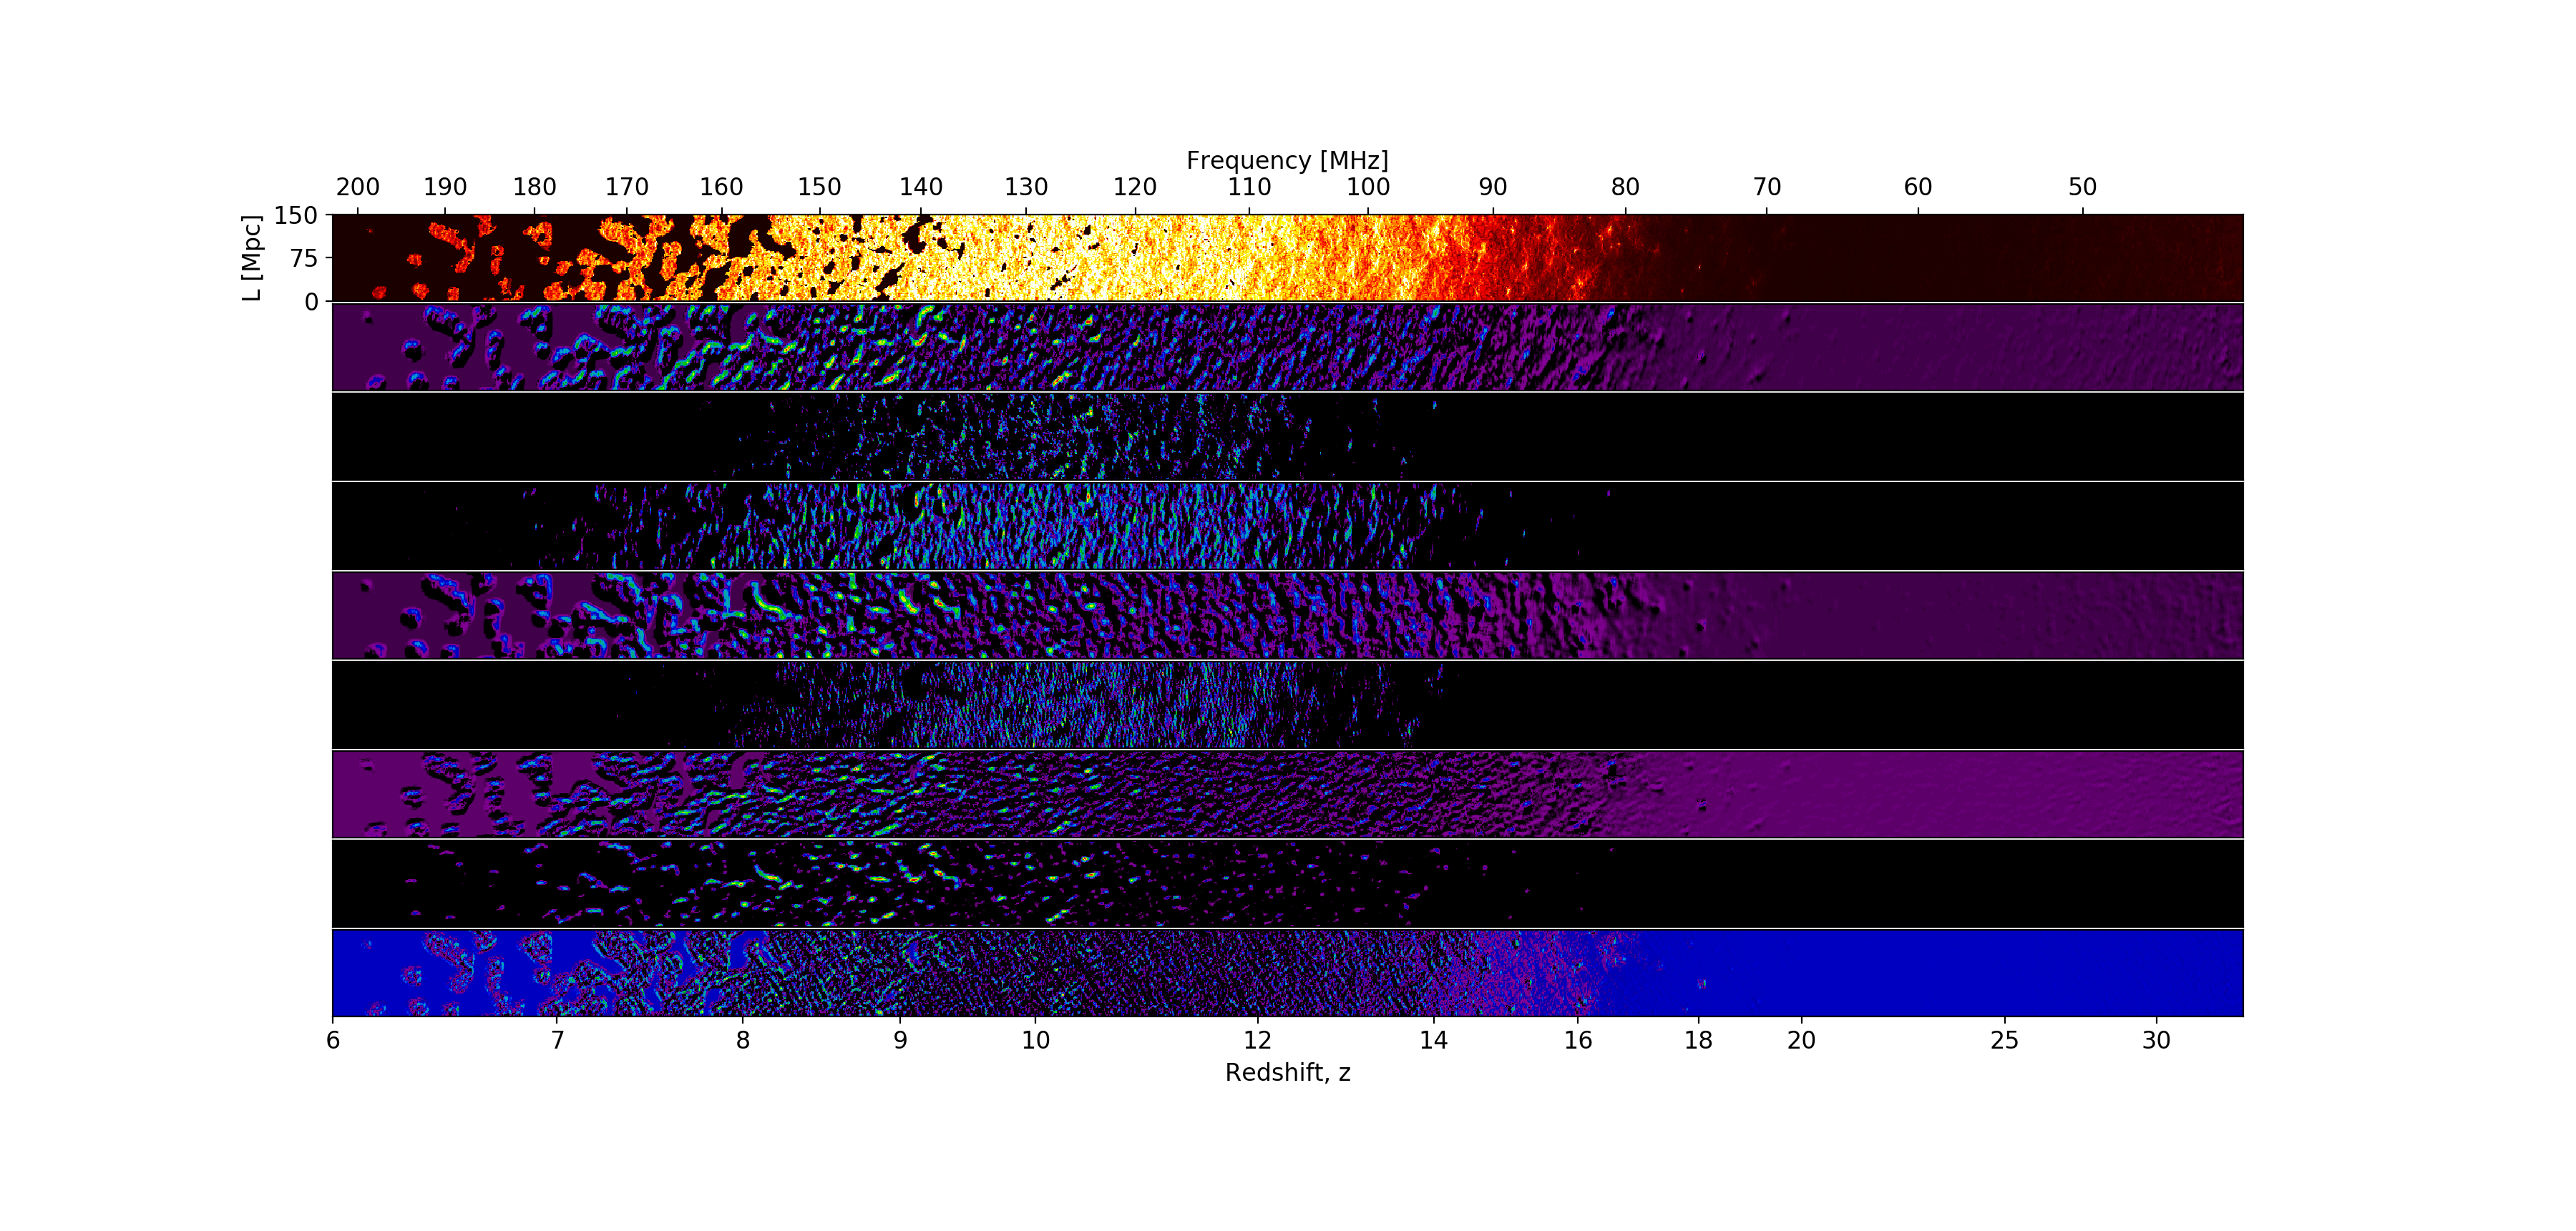

plots/CONV1_NUM_500


In [38]:
save_fig = True

layer_conv = model.get_layer('Conv-1') ### 'Pool-1'

numLC = 500 #979 #faint_ID #bright_ID ### 850 vs 960 | 977 979

#myLCtest = np.expand_dims( LC_test[numLC], axis=0 ) 
myLCtest = np.expand_dims( LC_train[numLC], axis=0 ) 

extent=[0,3300,0,150]

fig = plot_outConv( myLCtest, layer_conv, model, extent=extent, 
                    freq_label=[f_to_D, freq], redshift_label=[z_to_D, redshift] )

if save_fig: 
    print( "plots/CONV1_NUM_%d"%numLC )
    fig.savefig("plots/CONV1_NUM_%d"%numLC, bbox_inches='tight', format='pdf' )

    
if 0:
    layer_conv = model.get_layer('Conv-2') ### 'Pool-2'
    fig = plot_outConv( myLCtest, layer_conv, model, extent=extent, 
                        freq_label=[f_to_D, freq], redshift_label=[z_to_D, redshift] )

    if save_fig: 
        print( "plots/CONV2_NUM_%d"%numLC )
        fig.savefig("plots/CONV2_NUM_%d"%numLC, bbox_inches='tight', format='pdf')

### filters of the first Convolution layer

In [29]:
W = model.get_layer('Conv-1').get_weights()[0]
W = np.squeeze( W )
print( 'W shape: ',W.shape  )

#W = W[:,:,:,15]

W shape:  (10, 10, 8)


<IPython.core.display.Javascript object>


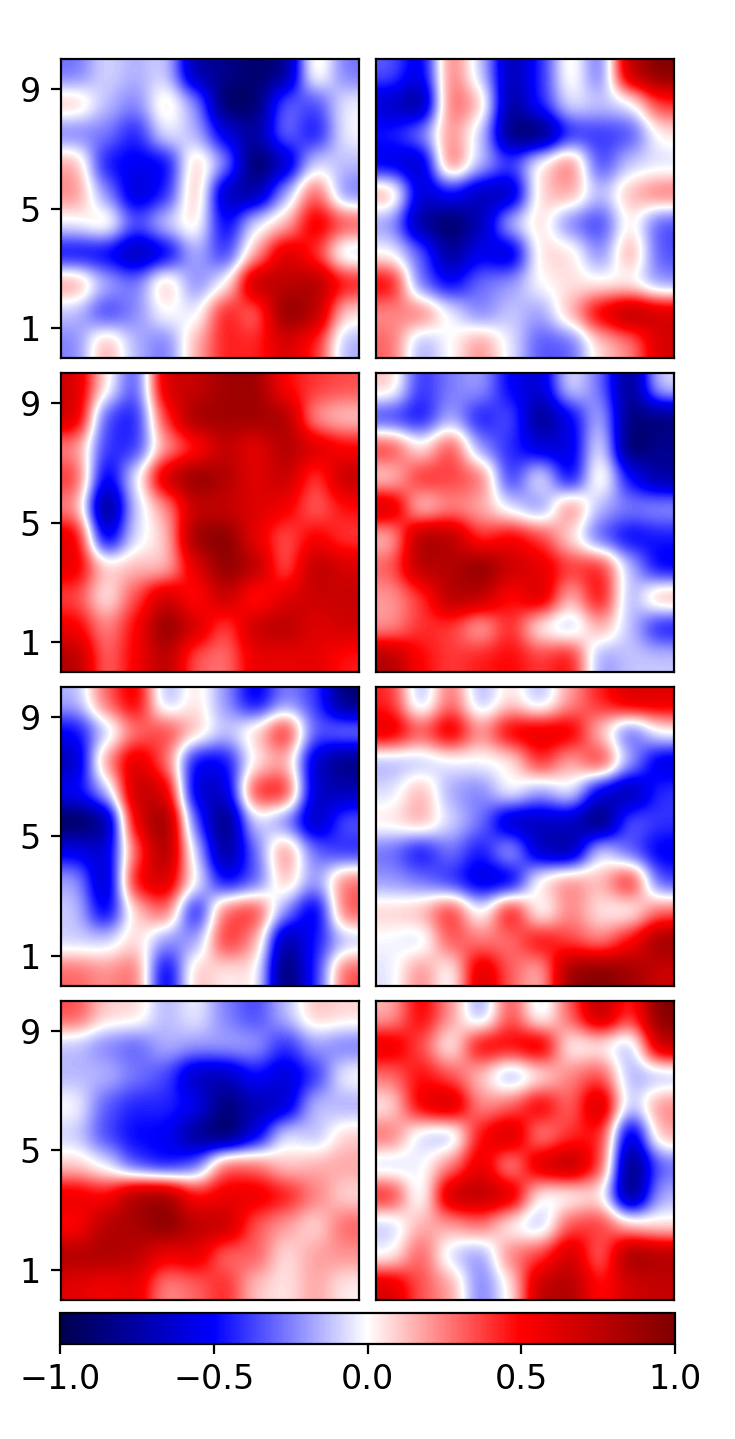

In [30]:
N_filter = W.shape[2]

N = 2
H =  N_filter//N

factor = 1.5
lrdim = 0.2*factor
tbdim = 0.2*factor
whspace = 0.05

plot_Largeur = factor*(N) + factor*(N-1) * whspace
dim_Largeur = lrdim + plot_Largeur + tbdim 

plot_Hauteur = factor*(H) + factor*(H-1) * whspace
dim_Hauteur = lrdim + plot_Hauteur + tbdim 

cbpad = 0.01
cbfraction = 0.05
cbspace = plot_Hauteur * ( cbfraction + cbpad )

dim_Hauteur += cbspace

#plt.rcParams[ 'font.size' ] = 6*factor

fig, axArray = plt.subplots( H, N, figsize=(dim_Largeur,dim_Hauteur)
                           )#, gridspec_kw={ 'height_ratios':[1,1,1,1,cbfraction + cbpad] } )

l = lrdim / dim_Largeur
r = 1 - l
b = tbdim / dim_Hauteur
t = 1 - b
fig.subplots_adjust( left=l, bottom=b, right=r, top=t, wspace=whspace, hspace=whspace )


W_norm = np.zeros_like( W )
Wmin = W.min()
Wmax = W.max()
W_norm = ( ( 2.0001*W -Wmax-Wmin ) / ( Wmax-Wmin ) )

#W_norm = W[:]

for i in range(N_filter):
    W_norm[...,i] = ( ( 1.99*W[:,:,i] - W[:,:,i].max()-W[:,:,i].min() ) / ( W[:,:,i].max()-W[:,:,i].min() ) )
    
    ax = axArray[ int(np.floor(i/2)), i%2 ]
    im = ax.imshow( W_norm[:,:,i], cmap=cm.seismic, interpolation='gaussian', vmin=-1, vmax=1, extent=[0,10,0,10] )
    #im = ax.imshow( W[:,:,i], cmap=cm.seismic, interpolation='gaussian', vmin=Wmin, vmax=Wmax )
    if i%2:
        ax.set_yticks([])
    else:
        ax.set_yticks([1,5,9])
    #if int(np.floor(i/2)) < (H-1):
    ax.set_xticks([])

#fig.subplots_adjust( right=0.8 )
fig.colorbar( im, ax=axArray.ravel().tolist() , orientation='horizontal', 
             fraction=cbfraction,
             pad=cbpad, 
             anchor=[0,1], 
             use_gridspec=False,
             ticks=[-1,-0.5,0,0.5,1]  
             ) #, shrink=1 )

#cax = fig.add_axes( [l, b, plot_Largeur, cbfraction + cbpad] )

    ### 'bilinear', 'bicubic', 'spline16', 'spline36', 'hanning', 'hamming', 'hermite', 'kaiser',
    ### 'quadric', 'catrom', 'gaussian', 'bessel', 'mitchell', 'sinc', 'lanczos'
    
save_fig = True
if save_fig: 
    #fig.savefig("plots/LC_NUM_%d"%numLC, bbox_inches='tight')
    pp = PdfPages("plots/Filters_conv1")
    pp.savefig(fig)
    pp.close()

# Test and bullshit

## recovery using the 200 over x and y of the 1000 test LC 

so 400 images per LC!

the results are just the mean and std over the 400 images

In [ ]:
from lightcone_functions import read_1_LC_2

num_of_the_LC_for_test = 255
BoxL = 200 
Nbox = 11

pred_raw_for_test_mean = np.zeros( [4, 10000] )
pred_raw_for_test_std  = np.zeros( [4, 10000] )

def normalize_array_inplace( array, vmin=-250, vmax=50 ):
        array -= vmin
        array /= (vmax-vmin)

        
for enum, num_of_the_LC_for_test in enumerate(test_select):
    
    print( enum )

    My_LC_for_test = np.zeros( (BoxL, BoxL, BoxL*Nbox), dtype=np.float32 ) ### 2D

    for i in range(Nbox):
        ax3 = i * BoxL
        My_LC_for_test[  :, :, ax3:ax3+BoxL ] = read_1_LC_2( i, ICs=3, param=None, delta=num_of_the_LC_for_test, verbose=False )

    My_LC_for_test = np.concatenate( (My_LC_for_test[:,:100   ,:], 
                                      My_LC_for_test[:,100:   ,:], 
                                      np.swapaxes( My_LC_for_test[:100,:,:], 0,1 ), 
                                      np.swapaxes( My_LC_for_test[100:,:,:], 0,1 ) ) )

    My_PARAM_for_test = read_1_param( param=None, ICs=3, delta=num_of_the_LC_for_test, verbose=True )[ [0,2,3,4] ]
    My_PARAM_for_test[3] /=1000.


    for i, a_slice in enumerate( My_LC_for_test ):
        np.clip( a_slice, -250, 50, out=a_slice );
        normalize_array_inplace( a_slice )
        My_LC_for_test[i] = a_slice

    My_LC_for_test = np.expand_dims( My_LC_for_test, 1 )

    #print(My_LC_for_test.shape)

    pred_for_test = model.predict( My_LC_for_test, verbose=False ) 
        
    pmin = Param_raw_val.min(axis=0)
    d    = Param_raw_val.max(axis=0) - pmin 
    pred_raw_for_test = pred_for_test*d+pmin

    pred_raw_for_test_mean[:,enum] = pred_raw_for_test.mean(axis=0)
    pred_raw_for_test_std[:,enum]  = pred_raw_for_test.std(axis=0)

In [ ]:
pred_raw_for_test_mean_2 = pred_raw_for_test_mean[:,:1000]

In [ ]:
pred_raw_for_test_std_2 = pred_raw_for_test_std[:,:1000]

In [ ]:
### SAVE THE RESULTS
#np.save( 'CNN_save/ALL_SLICE_PER_TEST_LC_RESULT_400000', [pred_raw_for_test_mean_2, pred_raw_for_test_std_2] )

In [ ]:
selection_for_corCoef = np.logical_not( np.isnan( pred_raw_for_test_std_2[0] ) )

In [ ]:
### correlation coef
p1 = 2
p2 = 3

for p1 in [0,1,2]:
    for p2 in range(p1+1,4):
        NUM = np.sum( ( pred_raw_for_test_std_2[p1,selection_for_corCoef]-pred_raw_for_test_std_2[p1,selection_for_corCoef].mean() )*\
                      ( pred_raw_for_test_std_2[p2,selection_for_corCoef]-pred_raw_for_test_std_2[p2,selection_for_corCoef].mean() ) )

        DENUM1 = np.sqrt( np.sum( ( pred_raw_for_test_std_2[p1,selection_for_corCoef]-pred_raw_for_test_std_2[p1,selection_for_corCoef].mean() )**2 ) )
        DENUM2 = np.sqrt( np.sum( ( pred_raw_for_test_std_2[p2,selection_for_corCoef]-pred_raw_for_test_std_2[p2,selection_for_corCoef].mean() )**2 ) )

        print(p1, p2, ' : ', NUM / DENUM1 / DENUM2 )

In [ ]:
num_param_to_plot = 2

plt.figure()
plt.plot( Param_raw_test[:,num_param_to_plot], pred_raw_for_test_mean_2[num_param_to_plot], '.' )

plt.plot( [Param_raw_test[:,num_param_to_plot].min(),Param_raw_test[:,num_param_to_plot].max()],
          [Param_raw_test[:,num_param_to_plot].min(),Param_raw_test[:,num_param_to_plot].max()] )

plt.figure()
num_param_to_plot_2 = 2
plt.plot( Param_raw_test[:,num_param_to_plot], pred_raw_for_test_std_2[num_param_to_plot_2], '.' )

plt.figure()
num_param_to_plot_2 = 3
plt.plot( pred_raw_for_test_std_2[num_param_to_plot], pred_raw_for_test_std_2[num_param_to_plot_2], '.' )
#plt.plot( pred_raw_for_test_mean_2[num_param_to_plot], pred_raw_for_test_mean_2[num_param_to_plot_2], '.' )

#plt.plot( Param_raw_test[:,num_param_to_plot], pred_raw_for_test_std_2[num_param_to_plot], '.' )

## LC FFT

In [ ]:
from lightcone_functions import read_1_LC_2

num_of_the_LC_for_test = 255
BoxL = 200 
Nbox = 11
dL = 300. / BoxL

### LOAD 1 LC
My_LC_for_test = np.zeros( (BoxL, BoxL, BoxL*Nbox), dtype=np.float32 ) ### 2D
for i in range(Nbox):
    ax3 = i * BoxL
    My_LC_for_test[  :, :, ax3:ax3+BoxL ] = read_1_LC_2( i, ICs=3, param=None, delta=num_of_the_LC_for_test, verbose=False )

My_PARAM_for_test = read_1_param( param=None, ICs=3, delta=num_of_the_LC_for_test, verbose=True )[ [0,2,3,4] ]
My_PARAM_for_test[3] /=1000.


In [ ]:
#from scipy.fftpack import fftn, ifftn

In [ ]:
### 3D fft of the LC
fft_LC = np.fft.rfftn( My_LC_for_test )

### keeping only the positive k 
# fft_LC_positive_only = fft_LC[:100,:100,:]

### k value, keeping only positive
k_PR = np.fft.fftfreq( BoxL, d=dL )[:BoxL//2]
k_PP = np.fft.fftfreq( BoxL*11, d=dL )[:11*BoxL//2]

# powerSpectrum_3D = np.absolute(fft_LC)**2

In [ ]:
### 3D reconstruction (need all k, symetric)
# recover_LC = np.fft.irfftn( fft_LC_2 )
# recover_LC_real = recover_LC_2.real #np.absolute( recover_LC )

In [ ]:
# plt.figure()
# plt.imshow( My_LC_for_test[:,:,1750] )

# plt.figure()
# plt.imshow( recover_LC_real[:,:,450] )

## find the zone in the input that change the output

In [ ]:
visualize_cam?

In [ ]:
filter_idx = 0 # [0,1,2,3]
modifiers = [None, 'negate', 'small_values' ]

heat_map = visualize_cam( model, layers_idx, filter_indices=filter_idx,
                          seed_input=myLCtest, grad_modifier=modifiers[0] ) # visualize_cam, visualize_saliency

#heat_map = visualize_cam( model, layers_idx, filter_indices=filter_idx,
#                          seed_input=myLCtest, 
#                          grad_modifier=modifiers[0],
#                          backprop_modifier='guided' ) # visualize_cam, visualize_saliency

gray_map = 0.2989 * heat_map[:,:,0] + 0.5870 * heat_map[:,:,1] + 0.1149 * heat_map[:,:,2]

In [ ]:
plt.figure( figsize=(10,1) )
plt.imshow( heat_map, cmap='jet' )

plt.figure( figsize=(10,1) )
plt.imshow( np.log10(gray_map), cmap='gray' )

# plt.figure( figsize=(20,2) )
# plt.imshow( np.squeeze(myLCtest), cmap='seismic_r' )

# plt.figure( figsize=(20,2) )
# plt.imshow( overlay( np.squeeze(myLCtest), np.clip(gray_map,0,1), alpha=0.3 ), cmap='seismic_r' )

### Activation map

In [ ]:
filter_idx = 0
img = visualize_activation( model, layers_idx, filter_indices=filter_idx, 
                            input_range=(0.,1.), 
                            tv_weight=10,
                            lp_norm_weight=0.,
                            verbose=False )

In [ ]:
model.predict( np.expand_dims( np.expand_dims( img[...,0], 0 ),0 ) )

In [ ]:
plt.figure(figsize=(10,2))
plt.imshow( np.squeeze(img) )

In [ ]:
filters = np.arange( get_num_filters(model.layers[layers_idx]) )

vis_images = []
for filter_idx in filters:
    print(filter_idx)
    #img = visualize_activation( model, layer_idx, filter_indices=filter_idx, 
    #                            tv_weight=0., 
    #                            input_modifiers=[Jitter(0.05)], 
    #                            input_range=(0.,1.) 
    #                           )
    
    img = visualize_activation( model, layers_idx, filter_indices=filter_idx, 
                            input_range=(0.,1.), 
                            tv_weight=5,
                            lp_norm_weight=0.,
                            seed_input=myLCtest,
                            verbose=False )
    
    #img = vis_utils.draw_text(img, 'Filter {}'.format(idx) )
    vis_images.append(img)

In [ ]:
print( model.predict( myLCtest ) )
print( model.predict( np.expand_dims( np.expand_dims( np.array( vis_images )[0,:,:,0], 0 ),0 ) ) )
print( model.predict( np.expand_dims( np.expand_dims( np.array( vis_images )[1,:,:,0], 0 ),0 ) ) )
print( model.predict( np.expand_dims( np.expand_dims( np.array( vis_images )[2,:,:,0], 0 ),0 ) ) )
print( model.predict( np.expand_dims( np.expand_dims( np.array( vis_images )[3,:,:,0], 0 ),0 ) ) )

In [ ]:
stitched = vis_utils.stitch_images( vis_images, cols=1 )
plt.figure( figsize=(10,4) )
plt.axis('off')
plt.imshow( stitched[:,:,0], cmap = 'seismic')

## test extract filters

In [ ]:
# model.layers

In [ ]:
from vis.visualization import get_num_filters
from vis.input_modifiers import Jitter

In [ ]:
layers_name = 'Conv-1'
layer_idx = vis_utils.find_layer_idx( model, layers_name )

filters = np.arange( get_num_filters(model.layers[layer_idx]) )

#filters =  [0,1,2,3,4,5]

vis_images = []
for idx in filters:
    print(idx)
    img = visualize_activation( model, layer_idx, filter_indices=idx, 
                                tv_weight=0., 
                                input_modifiers=[Jitter(0.05)], 
                                input_range=(0.,1.) 
                               )
    
    #img = vis_utils.draw_text(img, 'Filter {}'.format(idx) )
    vis_images.append(img)
    

new_vis_images = []
for i, idx in enumerate( filters ): # filters:
    print(idx)
    img = visualize_activation( model, layer_idx, filter_indices=idx, 
                                seed_input=vis_images[i],
                                tv_weight=0., 
                                input_modifiers=[Jitter(0.05)] 
                              )
    
    #img = vis_utils.draw_text(img, 'Filter {}'.format(idx) )
    new_vis_images.append(img)

In [ ]:
stitched = vis_utils.stitch_images( vis_images, cols=1 )
plt.figure( figsize=(10,8) )
plt.axis('off')
plt.imshow(stitched[:,:,0])

stitched = vis_utils.stitch_images( new_vis_images, cols=1 )
plt.figure( figsize=(10,8) )
plt.axis('off')
plt.imshow(stitched[:,:,0])

In [ ]:
np.array( vis_images ).shape

In [ ]:
(10*10*8+1) * 16

## test extract filters

In [ ]:
layer_conv1 = model.get_layer('Conv-2')

In [ ]:
inputs = [K.learning_phase()] + model.inputs

_convout1_f = K.function(inputs, [layer_conv1.output])
def convout1_f(X):
    return _convout1_f( [0] + [X] )

In [ ]:
convolutions[2].max()

In [ ]:
myLCtest = np.expand_dims( LC_test[750], axis=0 )

convolutions = np.squeeze( convout1_f( myLCtest ) )

print( np.array( convolutions ).shape )

n = np.array( convolutions ).shape[0]
#n = int( np.ceil( np.sqrt(n) ) )

fig = plt.figure( figsize=( 10,1*16 ) )

for i in range(len( convolutions )):
    ax = fig.add_subplot( n, 1, i+1 )
    ax.imshow( ( convolutions[i] ), cmap='viridis' )

In [ ]:
#W = model.layers[0].get_weights()[0]
W = layer_conv1.get_weights()[0]
W = np.squeeze( W )
print( 'W shape: ',W.shape  )

In [ ]:
N_filter = W.shape[2]

N = 2
K =  N_filter//N

factor = 1.5
lrdim = 0.05*factor
tbdim = 0.05*factor
whspace = 0.05


plot_Largeur = factor*(N) + factor*(N-1) * whspace
dim_Largeur = lrdim + Largeur + tbdim 

plot_Hauteur = factor*(K) + factor*(K-1) * whspace
dim_Hauteur = lrdim + Hauteur + tbdim 

cbpad = 0.01
cbfraction = 0.05
cbspace = plot_Hauteur * ( cbfraction + cbpad )

dim_Hauteur += cbspace

#plt.rcParams[ 'font.size' ] = 6*factor

fig, axArray = plt.subplots( K, N, figsize=(dim_Largeur,dim_Hauteur)
                           )#, gridspec_kw={ 'height_ratios':[1,1,1,1,cbfraction + cbpad] } )

l = lrdim / dim_Largeur
r = 1 - l
b = tbdim / dim_Hauteur
t = 1 - b
fig.subplots_adjust( left=l, bottom=b, right=r, top=t, wspace=whspace, hspace=whspace )


W_norm = np.zeros_like( W )
Wmin = W.min()
Wmax = W.max()
W_norm = ( ( 2.0001*W -Wmax-Wmin ) / ( Wmax-Wmin ) )

for i in range(N_filter):
    #W_norm[...,i] = ( ( 2.0001*W[:,:,i] - W[:,:,i].max()-W[:,:,i].min() ) / ( W[:,:,i].max()-W[:,:,i].min() ) )
    
    ax = axArray[ int(np.floor(i/2)), i%2 ]
    im = ax.imshow( W_norm[:,:,i], cmap=cm.seismic, interpolation='gaussian', vmin=-1, vmax=1 )
    #im = ax.imshow( W[:,:,i], cmap=cm.seismic, interpolation='gaussian', vmin=Wmin, vmax=Wmax )
    ax.set_xticks([])
    ax.set_yticks([])

#fig.subplots_adjust( right=0.8 )
fig.colorbar( im, ax=axArray.ravel().tolist() , orientation='horizontal', 
             fraction=cbfraction,
             pad=cbpad, 
             anchor=[0,1], use_gridspec=False,
             ticks=[-1,0,1]  ) #, shrink=1 )

#cax = fig.add_axes( [l, b, plot_Largeur, cbfraction + cbpad] )

    ### 'bilinear', 'bicubic', 'spline16', 'spline36', 'hanning', 'hamming', 'hermite', 'kaiser',
    ### 'quadric', 'catrom', 'gaussian', 'bessel', 'mitchell', 'sinc', 'lanczos'
    


In [ ]:
import numpy.ma as ma
def make_mos( img, Nrow, Ncol, border=1 ):
    Nimg = img.shape[-1]
    imshape = img.shape[:-1]
    
    mosaic = ma.masked_all( (Nrow * imshape[0] + (Nrow-1) * border,
                             Ncol * imshape[1] + (Ncol-1) * border),
                            dtype=np.float)
    paddedh = imshape[0]+border
    paddedw = imshape[1]+border
    for i in range(Nimg):
        row = int(np.floor(i/Ncol))
        col = i%Ncol
        
        mosaic[row * paddedh:row * paddedh + imshape[0],
               col * paddedw:col * paddedw + imshape[1]] = img[:,:,i]
    return mosaic

In [ ]:
import matplotlib.cm as cm

In [ ]:
plt.figure(figsize=(10,10))

#plt.imshow( make_mos(np.log10( np.abs(W_clip[:,:,:]) ) , 4, 4), cmap=cm.Greys )
plt.imshow( make_mos( W[:,:,:] , 4, 2), cmap=cm.Greys )

## test visu

In [ ]:
input_img = model.input

layer_name = 'Conv-1'
fiter_idx = 1

layer_output = model.get_layer( layer_name ).output
loss = K.mean( layer_output[:,fiter_idx,:,:] )

grads = K.gradients( loss, input_img )[0]
grads /= ( K.sqrt( K.mean( K.square(grads) ) ) +1.e-5 )

iterate = K.function( [input_img], [loss, grads] )

In [ ]:
input_img_data = np.random.random( (1, 1, 100, 2200) ) * 20 + 128

step = 1.
for i in range(20):
    loss_value, grads_value = iterate( [input_img_data] )
    print(i, loss_value, grads_value.min(), grads_value.max())
    input_img_data += grads_value * step

In [ ]:
from scipy.misc import imsave
def deprocess_img(x):
    x -=x.mean()
    x /=(x.std() + 1.e-5)
    x *=0.1
    x+=0.5
    x = np.clip(x,0,1)
    
    x *=255
    x = x.transpose((1,2,0))
    x = np.clip(x , 0, 255).astype('uint8')
    return x
    
img = input_img_data[:,0]
img = deprocess_img(img)
imsave( 'test_img.png', img )

plt.figure(figsize=(10,1) )
plt.imshow( img[:,:,1] )

In [ ]:
from keras.layers import Convolution2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization, Input
from keras.models import Sequential, Model

In [ ]:
LC_test.shape

In [ ]:
LC_test[0].max()

In [ ]:
model_test = Sequential()

model_test.add( BatchNormalization( input_shape=LC_test.shape[1:] ) )

model_test.summary()

#input_layer = Input( shape=LC_test.shape[1:], batch_shape=None )
#bn = BatchNormalization( input_shape=LC_test.shape[1:] ) 
#model_test = Model( input_layer, bn )

In [ ]:
out = model_test.predict( LC_test )

In [ ]:
out.shape

In [ ]:
out.max()

In [ ]:
np.mean( out )

In [ ]:
np.average( out, axis=0 )

In [ ]:
np.average( LC_test, axis=0 )